In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/user-guided-video-colourisation')

In [0]:
import torch
import numpy as np
import random
import os
import time
import pdb
from models import create_Inet
import torch
import torchvision
import torchvision.transforms as transforms
from scipy import interpolate
from utils.image_folder import ImageFolder
from utils import utils
from utils.utils import *
# from utils.Visualizer import Visualizer
import matplotlib.pyplot as plt
from IPython.display import clear_output
from options import DefaultConfig
opt = DefaultConfig()
torch.cuda.set_device(opt.gpu_ids)
torch.manual_seed(opt.seed)
torch.cuda.manual_seed_all(opt.seed)
np.random.seed(opt.seed)
random.seed(opt.seed)
torch.backends.cudnn.deterministic = True

Interaction Network: initialized


In [0]:
opt.dataroot_train = opt.dataroot + 'train/'
dataset_train = ImageFolder(opt.dataroot_train,
                       transform=transforms.Compose([
                                   transforms.Resize(opt.loadSize),
                                   transforms.RandomResizedCrop(opt.fineSize),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor()]))
dataset_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=opt.batch_size, shuffle=True)
dataset_train_size = len(dataset_train)
print('#training images = %d' % dataset_train_size)

opt.dataroot_val = opt.dataroot + 'subval/'
dataset_val = ImageFolder(opt.dataroot_val,
                       transform=transforms.Compose([
                                   transforms.Resize(opt.loadSize),
                                   transforms.RandomResizedCrop(opt.fineSize),
                                   transforms.ToTensor()]))
dataset_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=opt.batch_size_val, shuffle=True)
dataset_val_size = len(dataset_val)
print('#training images = %d' % dataset_val_size)

#training images = 22247
#training images = 635


In [0]:
model = create_Inet(opt)
model.setup(opt)
# print(model)
if opt.gpu_ids is not None:
    model.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



Interaction net was created


In [1]:
!nvidia-smi 

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

2020-03-30 10:21:35


Code optimisation:
1. rewrite sampling code using numpy
2. rewrite network structure and make it compataple for non-click input
3. rewrite validation code 

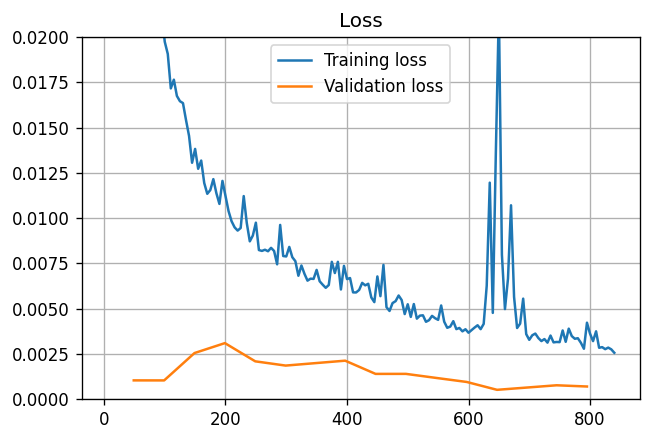

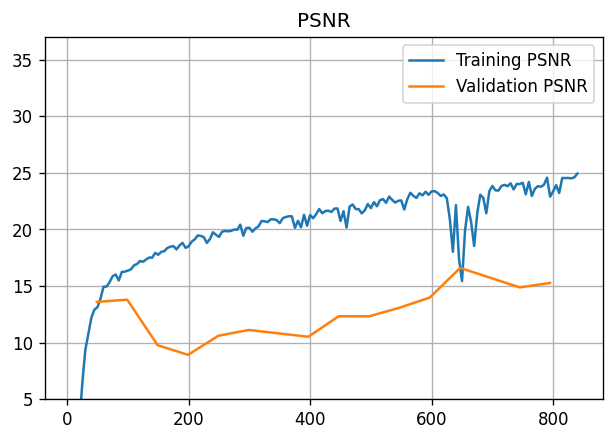

In [0]:
X_val = []
X_train = []

val_losses = []
train_losses = []
val_psnrs = []
train_psnrs = []

total_steps = 0
for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay):
    val_step = 1
    model_index = 0
    for i, data_raw in enumerate(dataset_loader_train):
        data_np = utils.get_colorization_data(data_raw, opt, p=opt.sample_p, first_round=True)
        data = ToCuda(data_np)

        total_steps += 1
        val_step += 1

        em_ab = model(data['gray'], data['clicks'], data['prev'])
        model.optimizer.zero_grad()
        loss = model.criterion(em_ab, data['ab'])
        loss.backward()
        model.optimizer.step()

        if val_step % opt.val_freq == 0:
            print('validation phase')
            val_loss = 0
            val_psnr = 0

            model.eval()
            for ii, data_raw_val in enumerate(dataset_loader_val):
                data_np_val = utils.get_colorization_data(data_raw_val, opt, p=opt.sample_p, first_round=True)
                data_val = ToCuda(data_np_val)
                em_ab_val = model(data_val['gray'], data_val['clicks'], data_val['prev'])

                scores = model.criterion(em_ab_val, data_val['ab'])
                em_ab_np_val = em_ab_val.detach().cpu().numpy()
                psnr = PSNR(data_np_val, em_ab_np_val, avg=False)

                val_loss += scores.detach().cpu().numpy()
                val_psnr += psnr
            val_psnrs.append(val_psnr / dataset_val_size)
            val_losses.append(val_loss / dataset_val_size)
            X_val.append(total_steps)
            model.train()
            
            # save model
            model_index += 1
            save_model(model, opt, epoch, model_index)

        if total_steps % opt.print_freq == 0:
            X_train.append(total_steps)
            # loss and PSNR
            em_ab_np = em_ab.detach().cpu().numpy()
            train_psnrs.append(PSNR(data_np, em_ab_np))
            train_losses.append(loss.detach().cpu().numpy())
            
            # plot loss and PSNR curve
            clear_output(wait=True)
            plt.figure(1)
            plt.rcParams['figure.dpi'] = 120 
            plt.ylim([0, .02])
            plt.title('Loss')
            plt.plot(X_train, train_losses, label="Training loss")
            plt.plot(X_val, val_losses, label="Validation loss")
            plt.grid(True)
            plt.legend()
            plt.show()

            plt.figure(2)
            plt.rcParams['figure.dpi'] = 120 
            plt.ylim([5, 37])
            plt.title('PSNR')
            plt.plot(X_train, train_psnrs, label="Training PSNR")
            plt.plot(X_val, val_psnrs, label="Validation PSNR")
            plt.grid(True)
            plt.legend()
            plt.show()




In [0]:
val_psnrs

In [0]:
#!sudo apt-get install -y psmisc
#!fuser /dev/nvidia*

In [0]:
#!kill 1529

In [0]:
            # interpolate validation loss and psnr
            X_loss = np.arange(len(train_psnr))
            X_psnr = np.arange(len(train_loss))
            interp1 = interpolate.interp1d(np.arange(len(val_loss)), val_loss)
            interp2 = interpolate.interp1d(np.arange(len(val_psnr)), val_psnr)
            interp_val_loss = interp1(X_loss)
            interp_val_psnr = interp2(X_psnr)